In [1]:
import networkx as nx
import scipy.io
import numpy as np
import cvxpy as cp
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

file = scipy.io.loadmat('capacities.mat')
capacities = file.get('capacities')
capacities = capacities.reshape(28,)
file = scipy.io.loadmat('traveltime.mat')
traveltime = file.get('traveltime')
traveltime = traveltime.reshape(28,)
file = scipy.io.loadmat('flow.mat')
flow = file.get('flow')
flow = flow.reshape(28,)
file = scipy.io.loadmat('traffic.mat')
traffic = file.get('traffic')

In [2]:
DG = nx.DiGraph()
DG.add_nodes_from(range(1,18))
edges = {}
for i,e in enumerate(traffic.T):
    tail = e.argmax()+1
    head = e.argmin()+1
    edges[(tail,head)] = i
    DG.add_edge(tail, head, capacity=capacities[i], weight=traveltime[i], minlen=1000)

x = {
    1:0,
    6:1,
    2:4,
    3:6,
    9:8,
    16:9,
    4:10,
    13:12,
    5:14
}
y = {
    1:0,
    5:-1,
    9:-3,
    6:-4,
    10:-8,
    13:-9,
    15:-10,
    16:-11,
    17:-12
}
pos = {
    1:[x[1],y[1]],
    2:[x[2],y[1]],
    3:[x[3],y[1]],
    4:[x[4],y[1]],
    5:[x[5],y[5]],
    6:[x[6],y[6]],
    7:[x[2],y[6]],
    8:[x[3],y[6]],
    9:[x[9],y[9]],
    10:[x[2],y[10]],
    11:[x[3],y[10]],
    12:[x[9],y[10]],
    13:[x[13],y[13]],
    14:[x[5],y[13]],
    15:[x[3],y[15]],
    16:[x[16],y[16]],
    17:[x[5],y[17]]
}

In [3]:
def draw_edge_flows(f, mf):
    if type(f) == dict:
        ee = [((u,v),c) for u,w in f.items() for v,c in w.items()]
    else:
        ee = zip(edges.keys(), f)
    nx.draw_networkx_edge_labels(
        DG,
        pos,
        edge_labels={(u,v):str(round(c/mf*100)) for (u,v),c in ee},
        font_color='blue',
#         font_size=6
    )

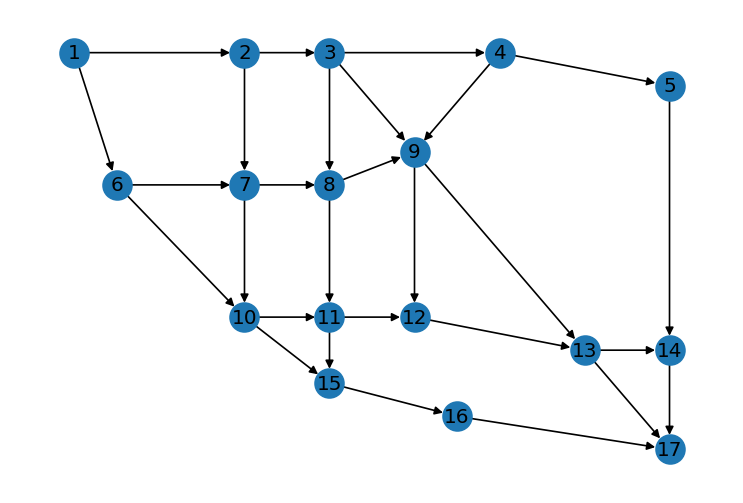

In [4]:
plt.figure(dpi=120)
nx.draw(DG, pos, with_labels=True)
plt.savefig('fig/graph.png')

The shortest (fastest) path is [1, 2, 3, 9, 13, 17], and the time needed to travel on it is 0.532996 hours


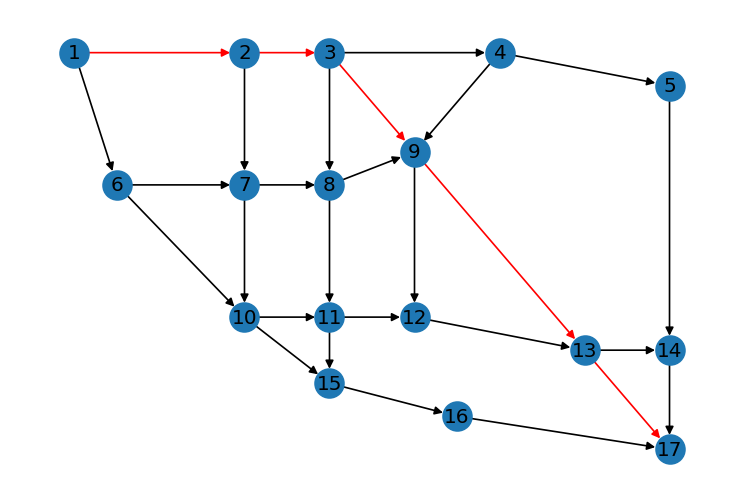

In [5]:
sp = nx.shortest_path(DG, 1, 17, weight='weight')
print(f"The shortest (fastest) path is {sp}, and the time needed to travel on it is {nx.shortest_path_length(DG, 1, 17, weight='weight')} hours")
colors = ['red' if u in sp and v in sp else 'black' for u,v in DG.edges]
plt.figure(dpi=120)
nx.draw(DG, pos, with_labels=True, edge_color=colors)
plt.savefig('fig/shortest_path.png')

The maximum flow is 22448, and it can be reached with the following flow assigments:
{1: {2: 8741, 6: 13707},
 2: {3: 8741, 7: 0},
 3: {4: 0, 8: 0, 9: 8741},
 4: {5: 0, 9: 0},
 5: {14: 0},
 6: {7: 4624, 10: 9083},
 7: {8: 4624, 10: 0},
 8: {9: 4624, 11: 0},
 9: {12: 7068, 13: 6297},
 10: {11: 825, 15: 8258},
 11: {12: 825, 15: 0},
 12: {13: 7893},
 13: {14: 3835, 17: 10355},
 14: {17: 3835},
 15: {16: 8258},
 16: {17: 8258},
 17: {}}


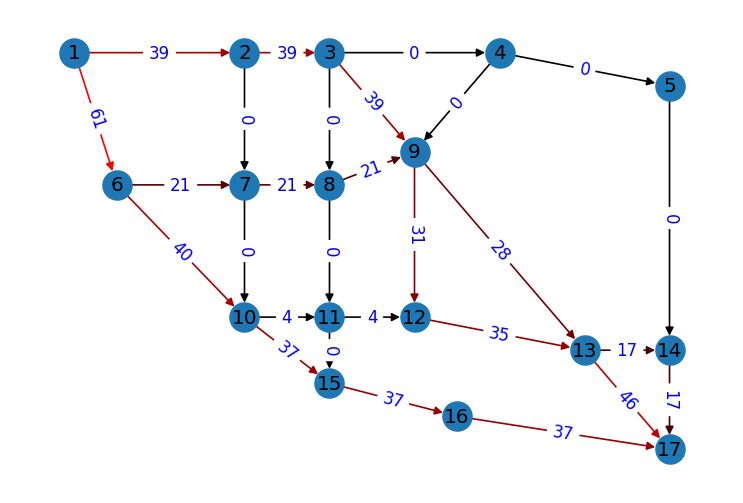

In [6]:
mf = nx.algorithms.flow.maximum_flow(DG, 1, 17)
print(f"The maximum flow is {mf[0]}, and it can be reached with the following flow assigments:")
pprint(mf[1])
fe_max = max([f for k,v in mf[1].items() for u,f in v.items()])
colors = [[mf[1][u][v]/fe_max, 0, 0] for u,v in DG.edges]
plt.figure(dpi=120)
nx.draw(DG, pos, with_labels=True, edge_color=colors)
draw_edge_flows(mf[1], mf[0])
plt.savefig('fig/max_flow.png')

The exogenous net flow vector is
(16806, 8570, 19448, 4957, -746, 4768, 413, -2, -5671, 1169, -5, -7131, -380, -7412, -7810, -3430, -23544)


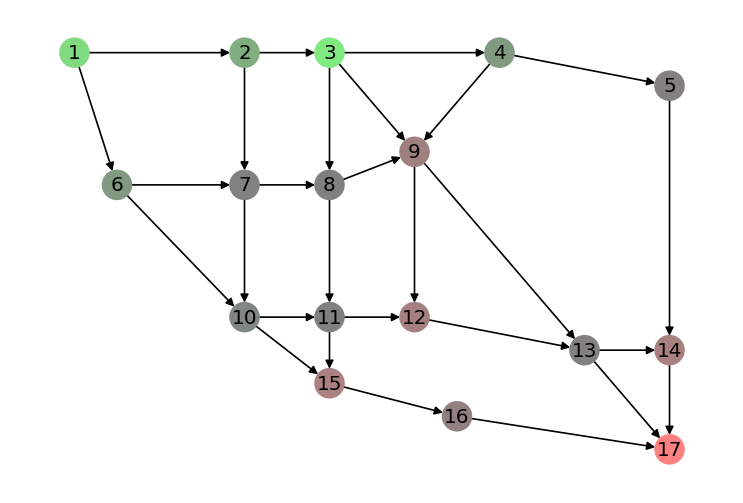

In [7]:
B = traffic
nu = B @ flow
print(f"The exogenous net flow vector is")
print(f"({', '.join([str(v) for v in nu])})")

white_base = 0.5
v_max = max(abs(nu))/(1-white_base)
colors = [[white_base+max(0, -v/v_max), white_base+max(0,v/v_max), white_base] for v in nu]
plt.figure(dpi=120)
nx.draw(DG, pos, with_labels=True, node_color=colors)
plt.savefig('fig/exogenous_net_flow_0.png')

In [8]:
tau = nu[0]
nu = np.zeros(17)
nu[0] = tau
nu[16] = -tau
print(f"The exogenous net flow vector that we will consider from now on is")
print(f"({', '.join([str(int(v)) for v in nu])})")

The exogenous net flow vector that we will consider from now on is
(16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806)


In [9]:
def tap(tau, f, constraints, density_cost, density_integral, density_derivative, G, pos, filenames):
    objective = cp.Minimize(cp.sum(density_cost))
    cp.Problem(objective, constraints).solve()
    # system optimum flow vector
    sof = f.value
    objective = cp.Minimize(cp.sum(density_integral))
    cp.Problem(objective, constraints).solve()
    # Wardrop equilibrium flow vector
    we0f = f.value
    # Compute tolls
    w = sof * density_derivative(sof)
    # Wardrop equilibrium flow vector with tolls
    objective = cp.Minimize(cp.sum(density_integral + cp.multiply(f, w)))
    cp.Problem(objective, constraints).solve()
    wewf = f.value
    end = '\n\n'
    print(f"The social optimum flow vector is:\n{sof}", end=end)
    print(f"The Wardrop equilibrium is:\n{we0f}", end=end)
    print(f"The tolls are:\n{w}", end=end)
    print(f"The Wardrop equilibrium with tolls is:\n{wewf}", end=end)
    print(f"The norm of the difference between the social optimum flow vector and the Wardrop equilibrium with tolls is:\n{np.linalg.norm(sof-wewf):.2f}")
    flows = (sof,we0f,wewf)
    for i,(f,n) in enumerate(zip(flows+(sof-we0f,sof-wewf), filenames)):
        plt.figure(dpi=120)
        if i > 2: # plot differences of flows
            if i == 3: # use the same reference for colors in case of differences
                fe_max = max(abs(f))
            print(f"The maximum difference is {max(abs(f)):.2f}")
            colors = []
            for e in DG.edges:
                tone = f[edges[e]]/fe_max # edges[e] is the position of e in the input files
                # show differences through colors
                colors.append([max(0,-tone), max(0,tone), 0])
#             draw_edge_flows(f, 1)
        else:
            fe_max = max(f)
            colors = [[f[edges[e]]/fe_max,0,0] for e in DG.edges] # edges[e] is the position of e in the input files
        nx.draw(G, pos, with_labels=True, edge_color=colors)
        draw_edge_flows(f, tau)
        plt.savefig(f"fig/{n}")
    return flows

The social optimum flow vector is:
[6.64219910e+03 6.05893789e+03 3.13232779e+03 3.13232589e+03
 1.01638009e+04 4.63831664e+03 3.00634073e+03 2.54263460e+03
 3.13154448e+03 5.83261212e+02 1.45164550e-02 2.92659559e+03
 1.89781986e-03 3.13232589e+03 5.52548426e+03 2.85427264e+03
 4.88644874e+03 2.21523712e+03 4.63720641e+02 2.33768761e+03
 3.31799129e+03 5.65567890e+03 2.37310712e+03 1.99567283e-03
 6.41411626e+03 5.50543301e+03 4.88645073e+03 4.88645073e+03]

The Wardrop equilibrium is:
[6.71564895e+03 6.71564803e+03 2.36740801e+03 2.36740792e+03
 1.00903510e+04 4.64539489e+03 2.80384316e+03 2.28356194e+03
 3.41848003e+03 9.22328268e-04 1.76829408e+02 4.17141061e+03
 8.92024178e-05 2.36740792e+03 5.44495611e+03 2.35317044e+03
 4.93333832e+03 1.84155266e+03 6.97110629e+02 3.03649261e+03
 3.05028094e+03 6.08677356e+03 2.58651143e+03 1.24029072e-04
 6.91874216e+03 4.95391934e+03 4.93333845e+03 4.93333845e+03]

The tolls are:
[1.92210631e+00 1.85064818e-01 5.16694986e-02 1.05176371e-01
 1.

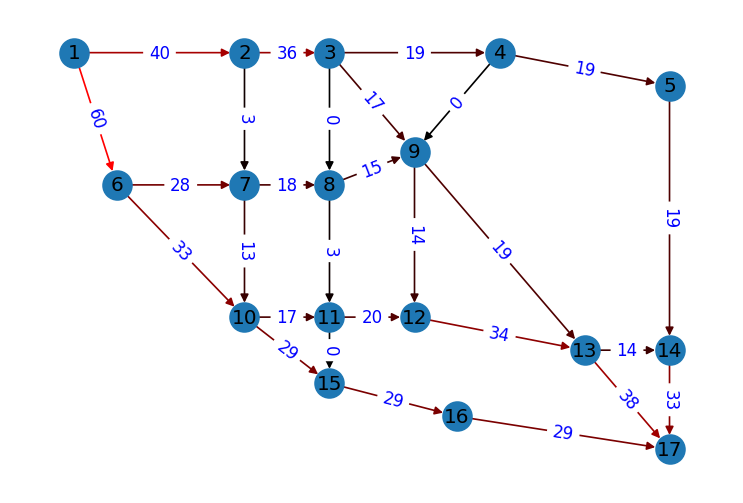

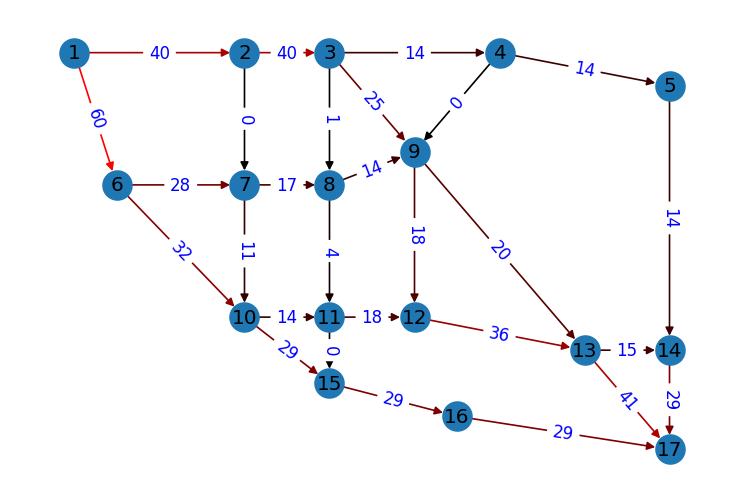

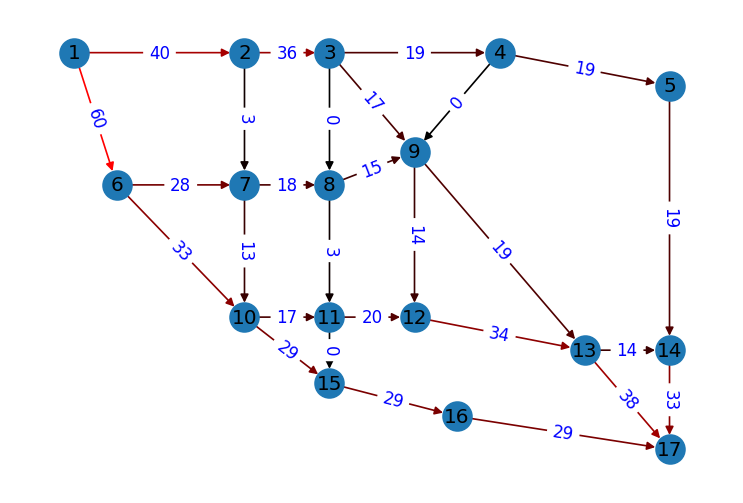

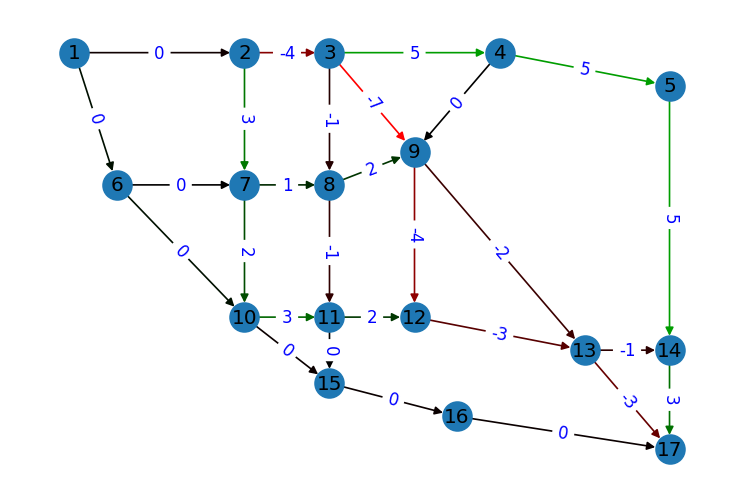

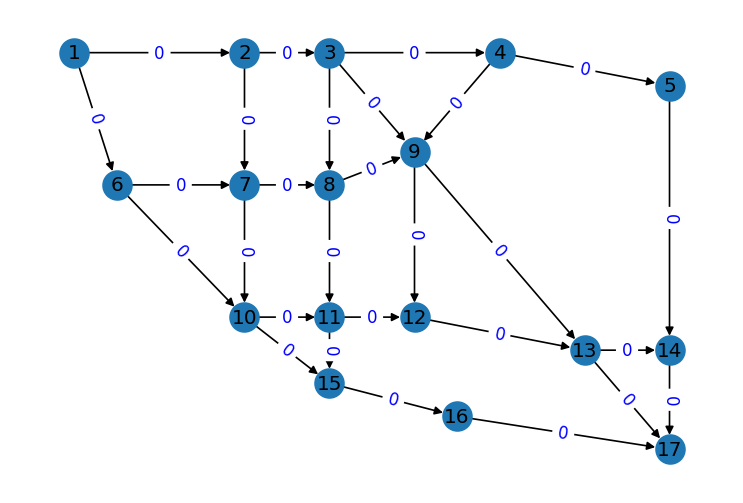

In [10]:
n_edges = len(DG.edges)
f = cp.Variable(n_edges)
constraints = [B @ f == nu, f >= 0, f <= capacities]

# express density cost function
num = traveltime * capacities
den = (1-cp.multiply(f,cp.inv_pos(capacities)))
density_cost = cp.multiply(num, cp.inv_pos(den)) - num

# express integral of density cost function
k = -cp.multiply(traveltime, capacities)
arg = 1 - cp.multiply(f, cp.inv_pos(capacities))
density_integral = cp.multiply(k, cp.log(arg))

# express derivative of density cost function, in function of the flow
density_derivative = lambda ff: num / np.square(capacities-ff)

filenames = ['social_optimum_0.png', 'wardrop_0_0.png', 'wardrop_w_0.png', 'diff_so_w0_0.png', 'diff_so_ww_0.png']
sof, we0f, wewf = tap(nu[0], f, constraints, density_cost, density_integral, density_derivative, DG, pos, filenames)

#### In the above output, we can see that the system optimum flow and the flow in Wardrop equilibrium with tolls are very close to each other, the differences are due to computational and approximation errors.

The social optimum flow vector is:
[6.65329658e+03 5.77466230e+03 3.41971657e+03 3.41971062e+03
 1.01527034e+04 4.64278036e+03 3.10584008e+03 2.66218478e+03
 3.00907935e+03 8.78634280e+02 7.42401749e-03 2.35493830e+03
 5.94907576e-03 3.41971062e+03 5.50992306e+03 3.04369256e+03
 4.88180506e+03 2.41557456e+03 4.43662730e+02 2.00804968e+03
 3.48735309e+03 5.49540277e+03 2.20377848e+03 2.20338871e-03
 6.30070364e+03 5.62348910e+03 4.88180726e+03 4.88180726e+03]

The Wardrop equilibrium is:
[6.78171861e+03 6.00489674e+03 3.26626641e+03 3.26625120e+03
 1.00242813e+04 4.66556349e+03 3.02889540e+03 2.64103584e+03
 3.03881982e+03 7.76821866e+02 2.40309308e+02 2.49832102e+03
 1.52097660e-02 3.26625120e+03 5.35871777e+03 2.88151993e+03
 4.89068780e+03 2.41348995e+03 6.28168876e+02 2.10055225e+03
 3.50968657e+03 5.61023882e+03 2.26259310e+03 2.23404877e-03
 6.38646554e+03 5.52884430e+03 4.89069003e+03 4.89069003e+03]

The tolls are:
[1.94584065e+00 1.52711415e-01 5.97224754e-02 1.23786840e-01
 1.

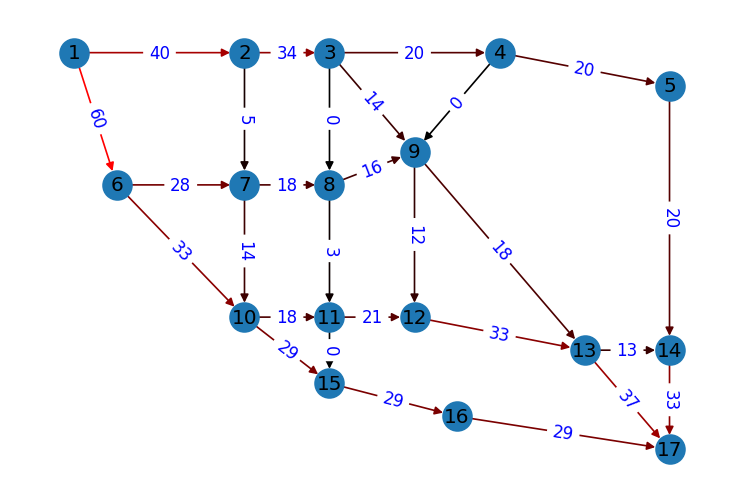

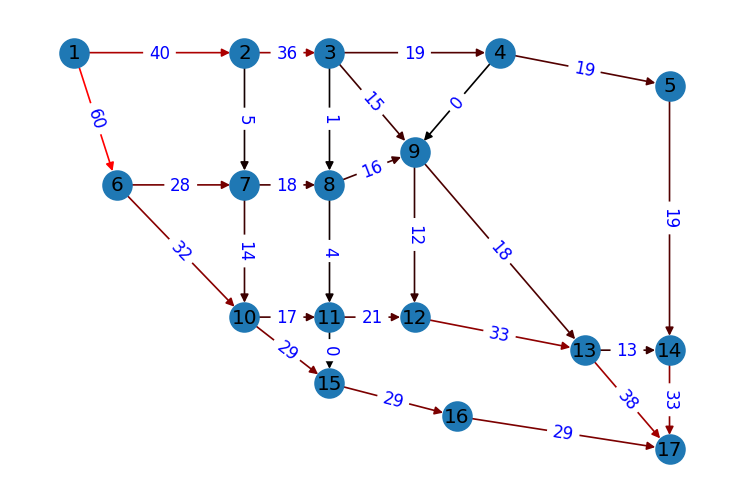

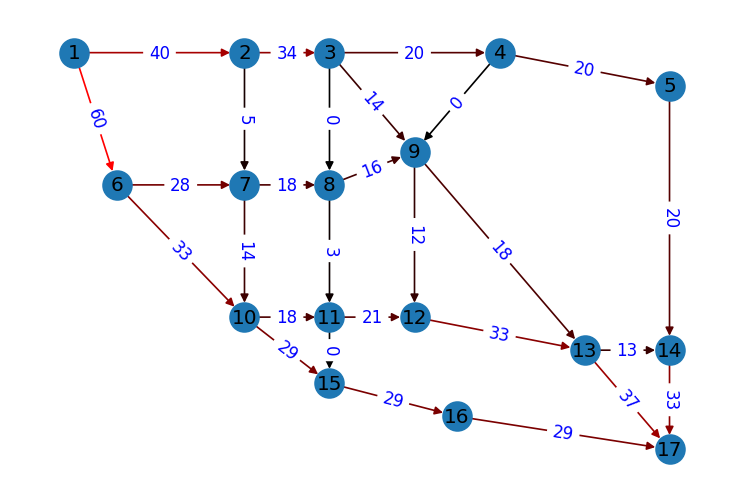

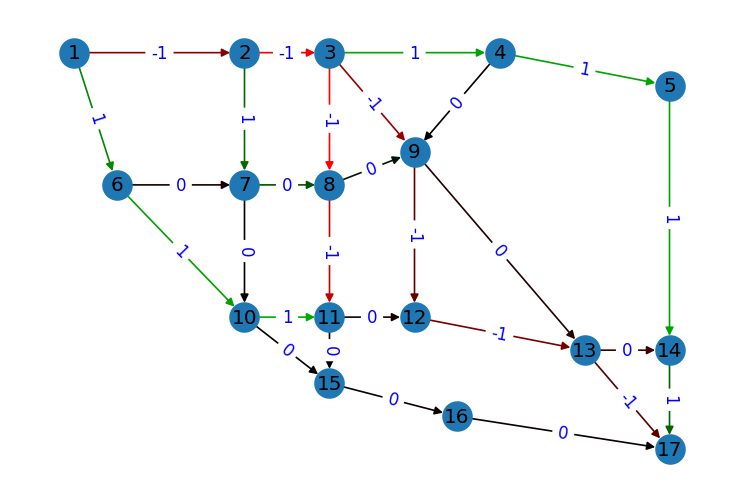

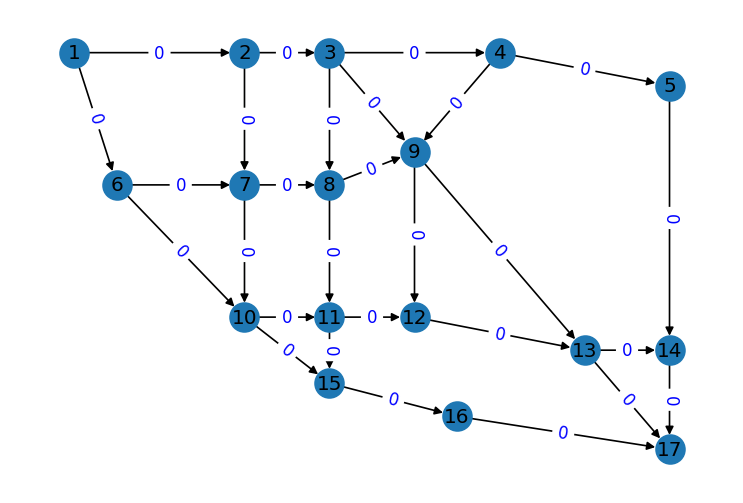

In [11]:
offset = cp.multiply(traveltime, f)
# update density cost function
density_cost -= offset
# update density cost integral
density_integral -= offset
# density cost derivative doesn't change

filenames = ['social_optimum_1.png', 'wardrop_0_1.png', 'wardrop_w_1.png', 'diff_so_w0_1.png', 'diff_so_ww_1.png']
sof, we0f, wewf = tap(nu[0], f, constraints, density_cost, density_integral, density_derivative, DG, pos, filenames)

#### In the above output, we can see again that the system optimum flow and the flow in Wardrop equilibrium with tolls are very close to each other, the differences are due to computational and approximation errors.